# Programming Assignment 05
Student: John Wu

In [1]:
import sys, os, nltk, string, csv, re
import numpy as np, tokenHelper as tkn
from collections import Counter

In [2]:
# loading in data, cannot use numpy methods for csv due to memory constraint
fName = os.path.join(os.getcwd(), '19991220-Excite-QueryLog.utf8.tsv')
with open(fName, 'r', encoding='utf-8') as f:
    reader = csv.reader(f, delimiter='\t')
    raw = list(reader)
timestamp = np.array([int(x[0]) for x in raw])
userID = np.array([x[1] for x in raw], dtype=np.str)
firstRank = np.array([int(x[2]) for x in raw])
query = [x[3] for x in raw]
qry = [s.lower() for s in query]
del raw, reader

## Simple Analysis

### Q1. What is the average number of queries per user id?

In [3]:
uid = np.unique(userID)
print('On average, %.2f queries per user.'%(len(userID)/len(uid)))

On average, 4.58 queries per user.


### Q2. Report the mean and median query length in both words and characters.
#### In Characters
First, query length in characters is simple. One just needs to find the length of the query string and calculate based on that.

In [4]:
tmp = [len(x) for x in qry]
print("Mean query length is %.2f characters."%np.mean(tmp))
print("Median query length is %.2f characters."%np.median(tmp))

Mean query length is 20.94 characters.
Median query length is 17.00 characters.


#### In Words
For query lengths in words, it is more complicated, as it would depend on tokenization process. We take a simple approach by:
1. Splitting query by any consecutive whitespaces
1. Strip all punctuation from individual tokens
1. Count the token if it's alphanumeric

The effect of this would be:
1. Counts strings like *"Chinese-American"* as one word.
1. Disregardes tokens like *"--"*, e.g. *"Leave -- no, come back" is* only 4 words.
1. Mix of letters and numbers, e.g. `python3` and `8.8.8.8` would count as one word. 

In [5]:
f = lambda x: sum([s.strip(string.punctuation).isalnum() for s in x.split()])
tmp = [f(x) for x in qry]
print("Mean query length is %.2f words."%np.mean(tmp))
print("Median query length is %.2f words."%np.median(tmp))

Mean query length is 3.19 words.
Median query length is 2.00 words.


### Q3. What percentage of queries are mixed case? All upper case? All lower case?
#### All upper case
One can use the numpy chararray built-in method of `isupper`. Note: returns `False` on entirely non-alphabetic strings.

In [6]:
qUpper = np.array([s.isupper() for s in query])
print( '{:.2%}'.format(np.mean(qUpper)) )

4.38%


#### All lower case
Likewise, one can use the numpy chararray built-in method of `islower`. Note: returns `False` on entirely non-alphabetic strings.

In [7]:
qLower = np.array([s.islower() for s in query])
print( '{:.2%}'.format(np.mean(qLower)) )

66.90%


#### Mixed case
Unfortunately, one cannot simply assume that if a string is not upper nor lower-case, it is mixed case. For example, `'12345'.islower()` and `'12345'.isupper()` are both `False`, yet it should not be counted as mixed-case either, as it is entirely numeric.

Therefore, we compare a string to both its upper and lower cased version. If they are not the same for both, it is mixed-case. This returns `False` on entirely non-alphabetic strings.

In [8]:
mixedCase = lambda s: s!=s.upper() and s!=s.lower()
print( '{:.2%}'.format( np.mean([mixedCase(s) for s in query]) ))

28.62%


### Q4. What percent of the time does a user request only the top 10 results?
Simply find the number of queries where first rank is 0

In [9]:
print('{:.2%}'.format(np.mean(firstRank==0)))

77.54%


### Q6. What are the 20-most common queries issued?
We use the [`Counter`](https://docs.python.org/2/library/collections.html#collections.Counter) class to count and retrieve the 20-most common quries. All queries are converted to lower case prior to counting.

In [10]:
qryCount = Counter(qry)
txt,n = zip(*qryCount.most_common(20))
print('\n'.join(['%02u: %s'%(n+1,x) for n,x in enumerate(txt)]))

01: sex
02: yahoo
03: internal site admin check from kho
04: pokemon
05: chat
06: porn
07: horoscopes
08: britney spears
09: mp3
10: games
11: hotmail
12: weather
13: maps
14: sitescope test
15: christmas
16: www.yahoo.com
17: yahoo.com
18: ebay
19: recipes
20: horoscope


### Q5. What percent of unique queries are in the form of an explicit question? What is the most common type of question?
This question can leverage the unique query counter built in Q6. According to [Interrogative word](https://en.wikipedia.org/wiki/Interrogative_word) on Wikipedia, a question can take two forms:
1. Wh-questions
   * Interrogative determiner: which, what
   * Interrogative pro-form: who, whom, where, whence, when, how, why
1. Yes-no questions
   * Conjugation of "be", e.g. "Are you hungry?"
   * Conjugation of "do", e.g. "Do you want fries?"
   * Conjugation of auxiliary verb, e.g. can and should

To solve this question, one can build regular expression for these questions forms. The regular expression requires the interrogative word to be the start of the query, or immediately follows a comma and a space or semicolon and a space. The regular expressions also require 2 or more combinations of space and one or more word characters, which is meant to eliminate erroneous matches like "will smith", "can opener", or "do good".

In [11]:
################################################################################
wh_det_re = re.compile(r"(^|\,\w|\;\w)(which|what)(\s\w+){2,}")
wh_pro_re = re.compile(r"(^|\,\w|\;\w)(who|whom|where|whence|" + \
                    r"when|how|why)(\s\w+){2,}")
yn_be_re = re.compile(r"(^|\,\w|\;\w)(are(n't)?|is(n't)?|am)(\s\w+){2,}")
yn_do_re = re.compile(r"(^|\,\w|\;\w)(do(es)?|did(n't)?)(\s\w+){2,}")
yn_aux_re = re.compile(r"(^|\,\w|\;\w)(can('t)?|could('t)?|will|won't" + \
                    r"|would(n't)?|should(n't)?)(\s\w+){2,}")
rgxIdx = lambda qs,rgx: np.array([True if rgx.findall(q) else False for q in qs])

In [12]:
wh_det = rgxIdx(qry,wh_det_re)
wh_pro = rgxIdx(qry,wh_pro_re)
yn_be = rgxIdx(qry,yn_be_re)
yn_do = rgxIdx(qry,yn_do_re)
yn_aux = rgxIdx(qry,yn_aux_re)
questions = np.logical_or.reduce((wh_det, wh_pro, yn_be, yn_do, yn_aux))
print('{:.2%}'.format( np.mean(questions) ))

13.75%


To find out which type of question is the most common, we simply find the largest sum in the boolean index of the various question types.

In [13]:
nQs = np.sum(np.vstack((wh_det, wh_pro, yn_be,yn_do,yn_aux)).T, axis=0)
['Interrogative determiner', 'Interrogative pro-form', 
 'Conjugation of "be"', 'Conjugation of "do"', 
 'Conjugation of auxiliary verb'][np.argmax(nQs)]

'Interrogative pro-form'

### Q7. What are the 20 most common non-stopwords appearing in queries?
For this question, we tokenize each query using NLTK module and remove the list of English stopwords as according to the NLTK module. The remaining terms are added to a [`Counter`](https://docs.python.org/2/library/collections.html#collections.Counter) and the 20 most common terms extracted.

In [14]:
wds = Counter()
for n,txt in enumerate(qry):
    wds.update(tkn.tokenizeNoPunctStopword(txt))
txt,n = zip(*wds.most_common(20))
print('\n'.join(['%02u: %s'%(n+1,x) for n,x in enumerate(txt)]))

01: find
02: free
03: pictures
04: sex
05: information
06: christmas
07: nude
08: 0
09: new
10: pics
11: buy
12: online
13: get
14: web
15: music
16: women
17: games
18: porn
19: cards
20: stories


### Q8. What percent of queries contain stopwords like ‘and’, ‘the’, ‘of’, ‘in’, ‘at’?
For each query, we compare the set of tokens from the query with the set of stopwords. If the intersection of the two sets is not empty, the query is considered to contain stopwords.

In [15]:
stopWords = tkn.engStopWords
hasStop = lambda txt: any(x in stopWords for \
                      x in tkn.tokenizeNoPunct(txt))
print('{:.2%}'.format(np.mean([hasStop(q) for q in qry])))

27.02%


### Q9. What are the 10 most common non-stopwords appearing in queries that contain the word download?
The process of this question is similar to that of Question 7. However, the terms are only added to Counter if the term download appears in the query. At the end of the processing, the term 'download' is removed from the Counter for obvious reasons.

In [16]:
downWds = Counter()
for n,txt in enumerate(qry):
    bags = tkn.tokenizeNoPunctStopword(txt)
    if 'download' in bags:
        downWds.update(bags)
downWds.pop('download', None) # needs to remove 'download' from words
txt,n = zip(*downWds.most_common(10))
print('\n'.join(['%02u: %s'%(n+1,x) for n,x in enumerate(txt)]))

01: 0
02: free
03: games
04: find
05: mp3
06: music
07: game
08: software
09: 10
10: full


### Q10. What percentage of queries were asked by only one user?
One cannot simply count the number of queries that only appears once, as it is possible that a query is asked by only one user but multiple times. Therefore, we need to get a unique set of query for each user and find the number of queries amongst all users that only appear once.

To do this, we first find the index that would sort the user list of the data set. With this, we could figure out where in the sorted user index do the user ID change. With these endpoints, we could easily pick out the queries that belong to each user. By iterating the same for each user, we would add the set of deduplicated query list to a Counter, while adding the non-dedpulicated queries to another counter. At the end of all users, we take all queries that were only asked by user, and add up the total number of times times they appear out of all the queries.

There seem to be a large number of users that search for the same query multiple times.

In [17]:
################################################################################
def q10(): # encapsulate in function for cleaniness
    qryAll = Counter() # counter for all queries, not user-unique
    qryUnq = Counter() # counter for user-unique queries
    srtUser = userID.argsort() # index to sort data by userIDs
    userChng = np.where( userID[srtUser][:-1] !=  userID[srtUser][1:])[0]+1
    userBeg = np.hstack((0,userChng))
    userEnd = np.hstack((userChng-1,userID.shape[0]))

    for beg,end in zip( userBeg, userEnd):
        qryIdx = srtUser[beg:end]
        userQueries = [qry[idx] for idx in qryIdx]
        qryUnq.update(set(userQueries))
        qryAll.update(userQueries)
        
    return np.sum([qryAll[q] for q,n in qryUnq.items() if n==1])
print('{:.2%}'.format( q10()/len(userID) )) 

51.96%


### Q11. Find 10 examples of misspelled words (but not 10 examples of the same misspelled word)
We can leverage the counter that we built in Q7 for most common non-stopwords. However, this time we could look at "words" that appear only a few times and are fully alphabetic. 

In [18]:
mispel = [w for w,n in wds.items() if 2<=n<=3 and w.isalpha()]
print(mispel[:50])

['workability', 'seyavash', 'ferdowsi', 'shahnameh', 'subalaksmi', 'molscript', 'assistanships', 'heliocopter', 'togepy', 'vanderheiden', 'vigalanty', 'cunei', 'shlomo', 'slonim', 'foutain', 'idhao', 'experinment', 'timbertop', 'scheidenhelm', 'abingdon', 'advest', 'nordan', 'behavoir', 'bricol', 'caracteristicas', 'impresoras', 'osservata', 'grantwriting', 'enalapril', 'backstreets', 'youngbloods', 'aweatpants', 'hause', 'achi', 'funhouse', 'joural', 'katt', 'lightbox', 'kahului', 'faffa', 'shofar', 'fictious', 'voyerismo', 'labrock', 'neuseeland', 'pinelander', 'batt', 'bilde', 'balsams', 'adrain']


Looking at the first 50 of these words, we find (with correct spelling in parenthesis): 
1. assistanships (assistantship)
1. heliocopter (helicopter)
1. togepy (togepi, a pokemon)
1. vigalanty (vigilante)
1. foutain (fountain)
1. idhao (idaho)
1. experinment (experiment)
1. behavoir (behavior or behaviour)
1. aweatpants (sweatpants)
1. joural (journal)

### Q12. Which occurs in queries more often "Al Gore" or "Johns Hopkins"? "Johns Hopkins" or "John Hopkins"?
#### Al Gore vs. Johns Hopkins
We can use the built-in string find function on lower case query for both "al gore" and "johns hopkins"

In [19]:
alGore = [q.find('al gore') >= 0 for q in qry]
JsHs = [q.find('johns hopkins') >= 0 for q in qry]
if np.sum(alGore) > np.sum(JsHs):
    print( 'Al Gore' )
else:
    print( 'Johns Hopkins' )

Al Gore


#### Johns Hopkins vs. John Hopkins
The same as the previous part.

In [20]:
JHs = [q.find('john hopkins') >= 0 for q in qry]
if np.sum(JHs) > np.sum(JsHs):
    print( 'John Hopkins' )
else:
    print( 'Johns Hopkins' )

Johns Hopkins


### Q13. How often do URLs appear in queries?
As defined in [RFC 1738](https://tools.ietf.org/html/rfc1738), a URL has the following syntax: `scheme:[//authority]path[?query][#fragment]`, e.g. https:<nolink>//www.<nolink>google.com/, ftp://www.microsoft.com/, irc://chat.freenode.net/, etc. While the scheme could be any arbitrary protocol, we explicitly search for the following protocols: http, https, gopher, mailto, news, nntp, telnet, ftp, file.

Many web users may only enter hostname of websites instead of the full URL (i.e. google.com instead of http:<nolink>//www.<nolink>google.com). However, such is not an URL, and would not be captured for this.

In [21]:
urlRE = re.compile(r'(https?://\w+|mailto:\w+|ftp://\w+|irc://\w+|file:\w+' + \
                   r'|nntp://\w|news://\w|telnet://\w)')
urlFound = rgxIdx(qry, urlRE)
print('{:.2%}'.format( np.mean(urlFound) )) 

0.29%


## Other Analysis

### Q16. How often is search engine “query” syntax used, like phrases in quotes, Boolean operators, or ‘+’ or ‘-‘ signs?
For this question, we can use regular expression. The explanation for the three sets of expressions are as followed:
* `\"\S+(\s+\S+)+\"`: matches two or more non-whitespaced words separated by whitespace between two quotation marks, e.g. "to be or not to be", "candy cane", or "master boot record, fdisk"
* `\s[\+-]\w+`: matches plus or minus sign directly in front of a word, but has to be preceded by a word boundary. e.g. matches "apple -fruits" but not "apple-fruits"
* `\s(AND|OR|NOT|&|\|)\s`: matches the boolean operators of "AND", "OR", "NOT", "&", or "|", but requires the operator to be surrounded by whitespaces, e.g. matches "apple AND computer", but not "appleANDcopmuter"

In [22]:
quotedRE = re.compile(r'\"\S+(\s+\S+)+\"')
plusMinusRE = re.compile(r'\b[\+-]\w+\b')
andOrRE = re.compile(r'\s(AND|OR|NOT|&|\|)\s')
seSyntax = rgxIdx(qry,quotedRE) | rgxIdx(qry,plusMinusRE) | rgxIdx(query,andOrRE)
print('{:.2%}'.format( np.mean(seSyntax) )) 

6.52%


### Q18. How does query volume change throughout the day?
We can count the number of searches per each minute after 9:00AM. Some math is needed on the timestamp to calculate the number of minutes elapsed. Once the time stamp has been converted, a `Counter` can be used to count the number of searches for minute. 

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib
matplotlib.rcParams['figure.figsize'] = (10,5)

In [24]:
ts_min = np.mod(np.floor(timestamp/100),100).astype(int)
ts_hr = np.floor(timestamp/10000).astype(int)-9
ts_minFrom9 = ts_hr*60 + ts_min
timeMinCount = Counter(ts_minFrom9)
xPlt, yPlt = zip(*timeMinCount.items()) 

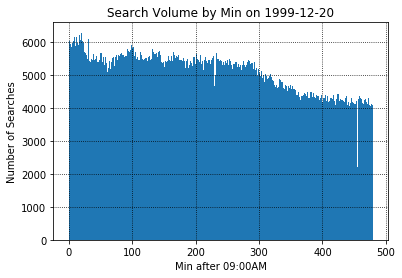

In [27]:
plt.bar(xPlt, yPlt, width=1.0)
plt.xlabel('Min after 09:00AM')
plt.ylabel('Number of Searches')
plt.grid(b=True, which='major', color='k', linestyle=':')
plt.title('Search Volume by Min on 1999-12-20')
plt.show()

The above chart plots number of searches against number of minutes after 9:00AM. The activity starts off high, and decreases slightly throughout the day until 5:00PM, though not monotonically. There seem to be three large drops throughout the day, proceeded by large spikes. This likely has to do with data collection error.

### Q19. What are the most popular websites mentioned in the queries?
We can use regular expression to search through the queries to match websites. This assumes that all website has the top-level domain name in either `.com`, `.org`, or `.net`, `.gov`, or `.edu`. While this is not comprehensive, it is a good estimate, as those TLD are by far the most popular.

In [26]:
webRE = re.compile(r'\w+\.(com|org|net|gov|edu)\b')
siteCount = Counter()
for q in qry:
    siteCount.update([match.group() for match in webRE.finditer(q)])
txt,n = zip(*siteCount.most_common(20))
print('\n'.join(['%02u: %s'%(n+1,x) for n,x in enumerate(txt)]))

01: yahoo.com
02: hotmail.com
03: amazon.com
04: aol.com
05: excite.com
06: bluemountain.com
07: geocities.com
08: ebay.com
09: weather.com
10: wwf.com
11: nick.com
12: nfl.com
13: msn.com
14: iwon.com
15: sex.com
16: pokemon.com
17: pch.com
18: gay.com
19: playboy.com
20: mtv.com
